In [42]:
from datetime import datetime
from scipy.stats import ttest_ind, ttest_rel
from DeathPrediction.collect_data import CollectData
from DeathPrediction import death_info
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
from scipy.stats import mannwhitneyu



In [49]:
def get_sister_dataframes(hives: list[tuple[str, str]], times_of_death, avg_by_day: bool = False) -> list[tuple[pd.DataFrame, pd.DataFrame]]:
    sister_hives = []
    for surviving_hive, died_hive in hives:
        end_date = times_of_death[died_hive]
        start_date = max(datetime(2022, 4, 10), end_date - pd.Timedelta(days=90))
        surviving_df = cd.get_temp_dataframe(surviving_hive, start_date, end_date)
        died_df = cd.get_temp_dataframe(died_hive, start_date, end_date)
        if avg_by_day:
            surviving_df = cd.get_temp_dataframe_averaged_by_day(surviving_df)
            died_df = cd.get_temp_dataframe_averaged_by_day(died_df)
        sister_hives.append((surviving_df, died_df))

    return sister_hives


def plot_sister_hives(sister_hives: list[tuple[pd.DataFrame, pd.DataFrame]], hive_names: list[tuple[str, str]]):
    for i in range(len(sister_hives)):
        fig, ax = plt.subplots()
        ax.plot(sister_hives[i][0]['Time'], sister_hives[i][0]['TemperatureDifference'], label="Survived")
        ax.plot(sister_hives[i][1]['Time'], sister_hives[i][1]['TemperatureDifference'], label="Died")
        ax.set_title(f"{hive_names[i][0]} vs {hive_names[i][1]}", fontsize=12)
        ax.set_xlabel("Date")
        ax.set_ylabel("Temperature Difference (°F)")
        ax.legend()
        
        # Set the date format to exclude the year
        date_format = DateFormatter("%m-%d")
        ax.xaxis.set_major_formatter(date_format)
        
        plt.show()

sister_hives = death_info.get_2022_opposing_pairs()
times_of_death = death_info.get_2022_deaths_early()

cd = CollectData()   

sister_hives_dfs = get_sister_dataframes(sister_hives, times_of_death, False)


KeyboardInterrupt: 

In [44]:
def test_difference(survived: pd.DataFrame, died: pd.DataFrame):
    stat, p_value = ttest_rel(survived['TemperatureDifference'], died['TemperatureDifference'])
    return stat, p_value



for i in range(len(sister_hives_dfs)):
    print(f"Test for {sister_hives[i][0]} vs {sister_hives[i][1]}")
    sister_hives_dfs[i][0].dropna(inplace=True)
    sister_hives_dfs[i][1].dropna(inplace=True)
    if len(sister_hives_dfs[i][0]) != len(sister_hives_dfs[i][1]):
        print("Dataframes have different lengths")
        continue
    
    sister_hives_dfs[i][0]['TemperatureDifference'] = sister_hives_dfs[i][0]['TemperatureDifference'].abs()
    sister_hives_dfs[i][1]['TemperatureDifference'] = sister_hives_dfs[i][1]['TemperatureDifference'].abs()
    stat, p_value = test_difference(sister_hives_dfs[i][0], sister_hives_dfs[i][1])
    print(f"Statistic: {stat}, p-value: {p_value}")
    print()

Test for AppMAIS1R vs AppMAIS1L
Dataframes have different lengths
Test for AppMAIS2L vs AppMAIS2R
Dataframes have different lengths
Test for AppMAIS5R vs AppMAIS5L
Dataframes have different lengths
Test for AppMAIS6L vs AppMAIS6R
Dataframes have different lengths
Test for AppMAIS8R vs AppMAIS8L
Dataframes have different lengths
Test for AppMAIS9R vs AppMAIS9L
Dataframes have different lengths
Test for AppMAIS11L vs AppMAIS11R
Dataframes have different lengths
Test for AppMAIS12R vs AppMAIS12L
Dataframes have different lengths


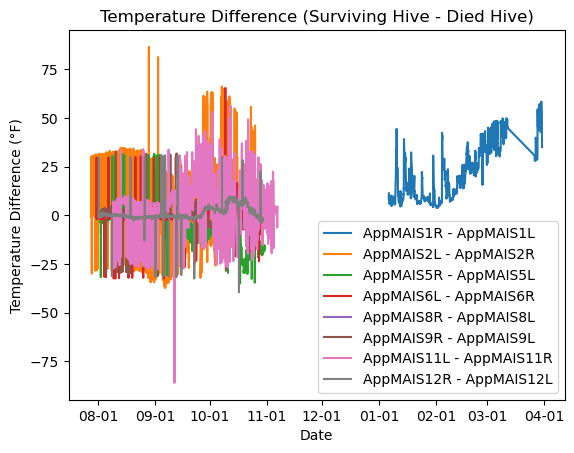

In [45]:
# plot_sister_hives(sister_hives_dfs, sister_hives)

def plot_temperature_difference(sister_hives: list[tuple[pd.DataFrame, pd.DataFrame]], hive_names: list[tuple[str, str]]):
    fig, ax = plt.subplots()

    for i in range(len(sister_hives)):
        # Merge dataframes on 'Time' to ensure they have the same length
        merged_df = pd.merge(sister_hives[i][0], sister_hives[i][1], on='Time', suffixes=('_survived', '_died'))
        
        # Calculate the difference in Temperature Difference
        temp_diff = merged_df['TemperatureDifference_survived'] - merged_df['TemperatureDifference_died']
        ax.plot(merged_df['Time'], temp_diff, label=f"{hive_names[i][0]} - {hive_names[i][1]}")

    ax.set_title("Temperature Difference (Surviving Hive - Died Hive)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature Difference (°F)")
    ax.legend()

    # Set the date format to exclude the year
    date_format = DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(date_format)

    plt.show()

plot_temperature_difference(sister_hives_dfs, sister_hives)

In [46]:
def normalize_days(sister_hives: list[tuple[pd.DataFrame, pd.DataFrame]], times_of_death: list[pd.Timestamp]):
    normalized_hives = []
    for i, (surviving_df, died_df) in enumerate(sister_hives):
        end_date = times_of_death[i]
        start_date = end_date - pd.Timedelta(days=60)

        surviving_df = surviving_df[(surviving_df['Time'] >= start_date) & (surviving_df['Time'] <= end_date)]
        died_df = died_df[(died_df['Time'] >= start_date) & (died_df['Time'] <= end_date)]

        normalized_hives.append((surviving_df, died_df))

    return normalized_hives

# Example usage
# normalized_sister_hives = normalize_days(sister_hives_dfs, times_of_death)
# plot_temperature_difference(normalized_sister_hives, sister_hives)

In [48]:
def perform_mann_whitney_test(sister_hives: list[tuple[pd.DataFrame, pd.DataFrame]]):
    results = []
    for surviving_df, died_df in sister_hives:
        # Convert TemperatureDifference to numeric, coercing errors to NaN
        surviving_df['TemperatureDifference'] = pd.to_numeric(surviving_df['TemperatureDifference'], errors='coerce')
        died_df['TemperatureDifference'] = pd.to_numeric(died_df['TemperatureDifference'], errors='coerce')

        survived_temp_diff = surviving_df['TemperatureDifference'].dropna().values
        died_temp_diff = died_df['TemperatureDifference'].dropna().values

        # Perform the Mann-Whitney U test
        stat, p_value = mannwhitneyu(survived_temp_diff, died_temp_diff, alternative='greater')
        results.append((stat, p_value))

    return results

# Example usage
test_results = perform_mann_whitney_test(sister_hives_dfs)
for i, (stat, p_value) in enumerate(test_results):
    print(f"Test for {sister_hives[i][0]} vs {sister_hives[i][1]}: Statistic = {stat}, p-value = {p_value}")

KeyboardInterrupt: 